In [1]:
import os
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import HookBase, hooks

from detectron2.data import DatasetMapper, build_detection_train_loader
import detectron2.utils.comm as comm

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
def register_frog_dataset(name, images_dir, json_file):
    register_coco_instances(name, {}, json_file, images_dir)
    #MetadataCatalog.get(name).set(thing_classes=["frog_stomach"])


In [3]:
def custom_config(num_classes):
    cfg = get_cfg()

    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.MASK_ON = True
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.RESNETS.DEPTH = 34
    cfg.MODEL.RESNETS.RES2_OUT_CHANNELS = 64

    # Solver
    cfg.SOLVER.BASE_LR = 0.0002
    cfg.SOLVER.MAX_ITER = 70000
    cfg.SOLVER.STEPS = (20, 10000, 20000, 30000, 40000, 50000)
    cfg.SOLVER.gamma = 0.5
    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.CHECKPOINT_PERIOD = 5000


    # Test
    cfg.TEST.DETECTIONS_PER_IMAGE = 20
    #cfg.TEST.EVAL_PERIOD = 5

    # INPUT
    cfg.INPUT.MIN_SIZE_TRAIN = (800,)

    # DATASETS
    cfg.DATASETS.TEST = ('frog_stomach_val',)
    cfg.DATASETS.TRAIN = ('frog_stomach_train',)

    # OUTPUT
    cfg.OUTPUT_DIR = r"detectron2_models"

    return cfg

In [4]:
# Register the dataset if not already registered
dataset_name = "frog_stomach_train"
if dataset_name not in DatasetCatalog.list():
    register_frog_dataset(dataset_name, "data/images", "data/split_segmentation_data/train.json")
    
dataset_name = "frog_stomach_val"
if dataset_name not in DatasetCatalog.list():
    register_frog_dataset(dataset_name, "data/images", "data/split_segmentation_data/val.json")



In [5]:
# Set up Detectron2 configuration
cfg = custom_config(num_classes=1)

In [ ]:
!tensorboard --logdir logs

In [6]:
class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))

    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)

            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, **loss_dict_reduced)

# Add these two lines to your code
cfg.TEST.EVAL_PERIOD = 5000  # Evaluate the model every 5000 iterations
cfg.TEST.KEYPOINT_OKS_SIGMAS = [.1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]


In [7]:
# Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.register_hooks([hooks.EvalHook(0, lambda: evaluate(trainer))])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=True)
trainer.train()

[05/14 13:50:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2):

Skip loading parameter 'backbone.fpn_lateral2.weight' to the model due to incompatible shapes: (256, 256, 1, 1) in the checkpoint but (256, 64, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral3.weight' to the model due to incompatible shapes: (256, 512, 1, 1) in the checkpoint but (256, 128, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral4.weight' to the model due to incompatible shapes: (256, 1024, 1, 1) in the checkpoint but (256, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral5.weight' to the model due to incompatible shapes: (256, 2048, 1, 1) in the checkpoint but (256, 512, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.bottom_up.res2.0.conv1.weight' to the model due to incompatible shapes: (64, 64, 1, 1) in the chec

[05/14 13:50:24 d2.engine.train_loop]: Starting training from iteration 0


/home/nicolaiep/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/14 13:50:36 d2.utils.events]:  eta: 9:30:28  iter: 19  total_loss: 1.669  loss_cls: 0.02978  loss_box_reg: 0.01189  loss_mask: 0.6537  loss_rpn_cls: 0.8329  loss_rpn_loc: 0.1921    time: 0.4853  last_time: 0.4290  data_time: 0.0967  last_data_time: 0.0369   lr: 5.762e-07  max_mem: 3433M
[05/14 13:50:45 d2.utils.events]:  eta: 9:18:36  iter: 39  total_loss: 0.9849  loss_cls: 0.01599  loss_box_reg: 0.01457  loss_mask: 0.6104  loss_rpn_cls: 0.2596  loss_rpn_loc: 0.05951    time: 0.4766  last_time: 0.4716  data_time: 0.0641  last_data_time: 0.0646   lr: 9.722e-07  max_mem: 3433M
[05/14 13:50:55 d2.utils.events]:  eta: 9:21:41  iter: 59  total_loss: 0.7676  loss_cls: 0.03639  loss_box_reg: 0.03584  loss_mask: 0.6121  loss_rpn_cls: 0.03495  loss_rpn_loc: 0.02728    time: 0.4751  last_time: 0.4616  data_time: 0.0550  last_data_time: 0.0212   lr: 1.3682e-06  max_mem: 3433M
[05/14 13:51:05 d2.utils.events]:  eta: 9:28:01  iter: 79  total_loss: 0.6705  loss_cls: 0.03266  loss_box_reg: 0.0523

NameError: name 'evaluate' is not defined

In [24]:
import cv2
from detectron2.structures import BoxMode

def verify_loaded_annotations(dataset_dict):
    for idx, d in enumerate(dataset_dict):
        img_path = d["file_name"]
        height, width = cv2.imread(img_path).shape[:2]
        annos = d["annotations"]
        for anno in annos:
            assert anno["bbox_mode"] == BoxMode.XYXY_ABS, "Annotation bbox_mode is not BoxMode.XYXY_ABS"
            assert anno["category_id"] in [0, 1], "Annotation category_id is not 0 or 1"
            assert all(coord >= 0 for coord in anno["bbox"]), "Negative coordinates in bbox"
            assert anno["bbox"][2] <= width and anno["bbox"][3] <= height, "bbox is larger than image size"

# Get the dataset_dicts for both train and val
dataset_dicts_train = DatasetCatalog.get("frog_stomach_train")
dataset_dicts_val = DatasetCatalog.get("frog_stomach_val")

# Verify that the annotations for each image in the dataset_dicts are valid
verify_loaded_annotations(dataset_dicts_train)
verify_loaded_annotations(dataset_dicts_val)


[05/14 13:42:10 d2.data.datasets.coco]: Loading data/split_segmentation_data/train.json takes 3.81 seconds.
WARNING [05/14 13:42:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/14 13:42:10 d2.data.datasets.coco]: Loaded 835 images in COCO format from data/split_segmentation_data/train.json
WARNING [05/14 13:42:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/14 13:42:10 d2.data.datasets.coco]: Loaded 179 images in COCO format from data/split_segmentation_data/val.json


AssertionError: Annotation bbox_mode is not BoxMode.XYXY_ABS

In [8]:
import json

# Load the json file
with open("data/split_segmentation_data/train.json") as f:
    data = json.load(f)

# Create a set to store ids
id_set = set()

# Create a list to store duplicate ids
duplicate_ids = []

# Iterate over annotations
for i, ann in enumerate(data["annotations"]):
    # If the id is already in the set, it's a duplicate
    if ann["id"] in id_set:
        duplicate_ids.append(ann["id"])
    # Add the id to the set
    id_set.add(ann["id"])

# Print duplicate ids
if duplicate_ids:
    print(f"Found duplicate ids: {duplicate_ids}")
else:
    print("No duplicate ids found.")


Found duplicate ids: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173

In [11]:
import json

# Load the json file
with open("data/split_segmentation_data/test.json") as f:
    data = json.load(f)

# Create a set to store ids
id_set = set()

# Iterate over annotations
for i, ann in enumerate(data["annotations"]):
    # If the id is already in the set, assign a new id
    if ann["id"] in id_set:
        ann["id"] = max(id_set) + 1
    # Add the id to the set
    id_set.add(ann["id"])

# Write the data back to the json file
with open("data/split_segmentation_data/test.json", "w") as f:
    json.dump(data, f)


In [15]:
import json
from PIL import Image
import os

# Load the json file
with open("data/split_segmentation_data/test.json") as f:
    data = json.load(f)

# Directory where your images are stored
image_dir = "data/images"

# Iterate over images
for img in data["images"]:
    # Open the image file
    with Image.open(os.path.join(image_dir, img["file_name"])) as im:
        # Get the width and height of the image
        width, height = im.size

    # Update the image dictionary with width and height
    img["width"] = width
    img["height"] = height

# Write the updated data back to the json file
with open("data/split_segmentation_data/test.json", "w") as f:
    json.dump(data, f)


In [16]:

# Your model configuration already has the number of classes
num_classes = cfg.MODEL.ROI_HEADS.NUM_CLASSES
print(f'Number of classes in the model configuration: {num_classes}')

# Assuming 'dataset_name' is the name of your dataset
dataset_dicts = DatasetCatalog.get(dataset_name)
class_labels = set()
for item in dataset_dicts:
    for ann in item['annotations']:
        class_labels.add(ann['category_id'])

print(f'Number of unique class labels in the dataset: {len(class_labels)}')



Number of classes in the model configuration: 1
WARNING [05/14 13:09:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/14 13:09:46 d2.data.datasets.coco]: Loaded 179 images in COCO format from data/split_segmentation_data/val.json
Number of unique class labels in the dataset: 1


In [17]:
# Assuming 'dataset_name' is the name of your dataset
invalid_labels = set()
for item in dataset_dicts:
    for ann in item['annotations']:
        if ann['category_id'] < 0 or ann['category_id'] >= num_classes:
            invalid_labels.add(ann['category_id'])

if invalid_labels:
    print(f'Invalid class labels found: {invalid_labels}')
else:
    print('No invalid class labels found.')


Invalid class labels found: {1020}


In [19]:
invalid_label = 1020
for item in dataset_dicts:
    for ann in item['annotations']:
        if ann['category_id'] == invalid_label:
            print(f'Image {item["file_name"]} has an annotation with invalid class label {invalid_label}.')


Image data/images/01258_locA_2008_spring_0512.jpg has an annotation with invalid class label 1020.
Image data/images/IMG_2361_0503.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2007_fall_00847_0512.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2020_fall_0700_0149.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2021_fall_0023_0452.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2021_fall_0031_0453.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2021_fall_0048_0455.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2021_fall_0096_0460.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2021_fall_0110_0462.jpg has an annotation with invalid class label 1020.
Image data/images/locA_2021_spring_0067_0079.jpg has an annotation with invalid class label 1020.
Image data/images/locB_2010_spring_0049_0181.

In [22]:
import json

# Load the JSON file
with open('data/split_segmentation_data/val.json', 'r') as f:
    data = json.load(f)

# Check each annotation for the invalid class label
invalid_label = 1020
for image in data['images']:
    for annotation in data['annotations']:
        if annotation['image_id'] == image['id'] and annotation['category_id'] == invalid_label:
            print(f"Image {image['file_name']} has an annotation with invalid class label {invalid_label}.")


In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

def test_model(cfg):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model

    predictor = DefaultPredictor(cfg)

    # Load the test dataset
    dataset_name = "frog_stomach_test"
    if dataset_name not in DatasetCatalog.list():
        register_frog_dataset(dataset_name, "data/images", "data/split_segmentation_data/test.json")

    evaluator = COCOEvaluator(dataset_name, ("bbox", "segm"), False, output_dir="./output/")
    val_loader = build_detection_test_loader(cfg, dataset_name)

    return inference_on_dataset(predictor.model, val_loader, evaluator)


In [10]:
test_model(cfg)

[05/15 05:28:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2_models/model_final.pth ...
[05/15 05:28:28 d2.data.datasets.coco]: Loaded 179 images in COCO format from data/split_segmentation_data/test.json
[05/15 05:28:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/15 05:28:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/15 05:28:28 d2.data.common]: Serializing 179 elements to byte tensors and concatenating them all ...
[05/15 05:28:28 d2.data.common]: Serialized dataset takes 0.42 MiB
[05/15 05:28:28 d2.evaluation.evaluator]: Start inference on 179 batches
[05/15 05:28:32 d2.evaluation.evaluator]: Inference done 11/179. Dataloading: 0.0209 s/iter. Inference: 0.0961 s/iter. Eval: 0.0688 s/iter. Total: 0.1859 s/iter. ETA=0:00:31
[05/15 05:28:37 d2.evaluation.evaluator

OrderedDict([('bbox',
              {'AP': 86.90756759513056,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': nan,
               'APl': 86.90756759513056}),
             ('segm',
              {'AP': 89.00972814718041,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': nan,
               'APl': 89.00972814718041})])

In [11]:
# Load the test dataset
dataset_name = "frog_stomach_test"
if dataset_name not in DatasetCatalog.list():
    register_frog_dataset(dataset_name, "data/images", "data/split_segmentation_data/test.json")

test_loader = build_detection_test_loader(cfg, dataset_name)

[05/15 05:52:36 d2.data.datasets.coco]: Loading data/split_segmentation_data/test.json takes 1.76 seconds.
[05/15 05:52:36 d2.data.datasets.coco]: Loaded 179 images in COCO format from data/split_segmentation_data/test.json
[05/15 05:52:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/15 05:52:36 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/15 05:52:36 d2.data.common]: Serializing 179 elements to byte tensors and concatenating them all ...
[05/15 05:52:36 d2.data.common]: Serialized dataset takes 0.42 MiB


In [13]:
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
from matplotlib import pyplot as plt

def display_predictions(cfg, dataset_name, n_images=5):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
    predictor = DefaultPredictor(cfg)

    dataset_dicts = DatasetCatalog.get(dataset_name)
    for d in random.sample(dataset_dicts, n_images):    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v = Visualizer(im[:, :, ::-1],
                       metadata=MetadataCatalog.get(dataset_name), 
                       scale=0.8, 
                       instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize = (14, 10))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.show()


[05/15 05:56:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2_models/model_final.pth ...
[05/15 05:56:29 d2.data.datasets.coco]: Loading data/split_segmentation_data/test.json takes 1.68 seconds.
[05/15 05:56:29 d2.data.datasets.coco]: Loaded 179 images in COCO format from data/split_segmentation_data/test.json


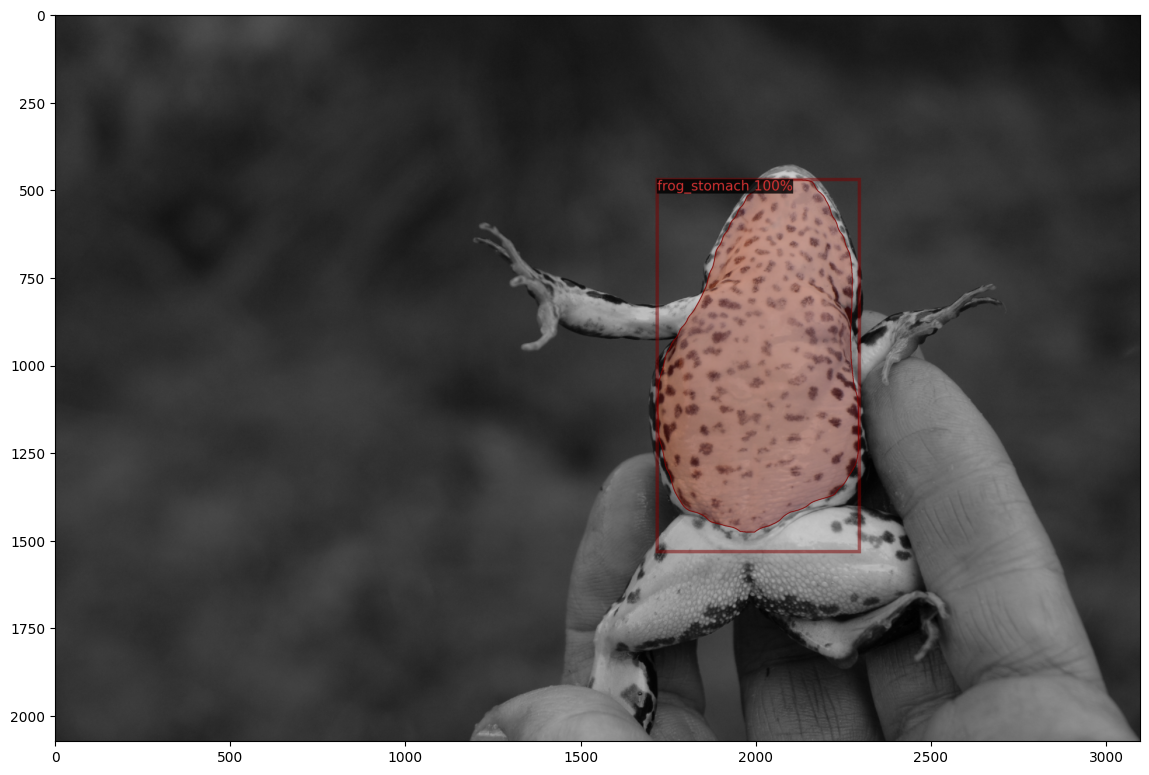

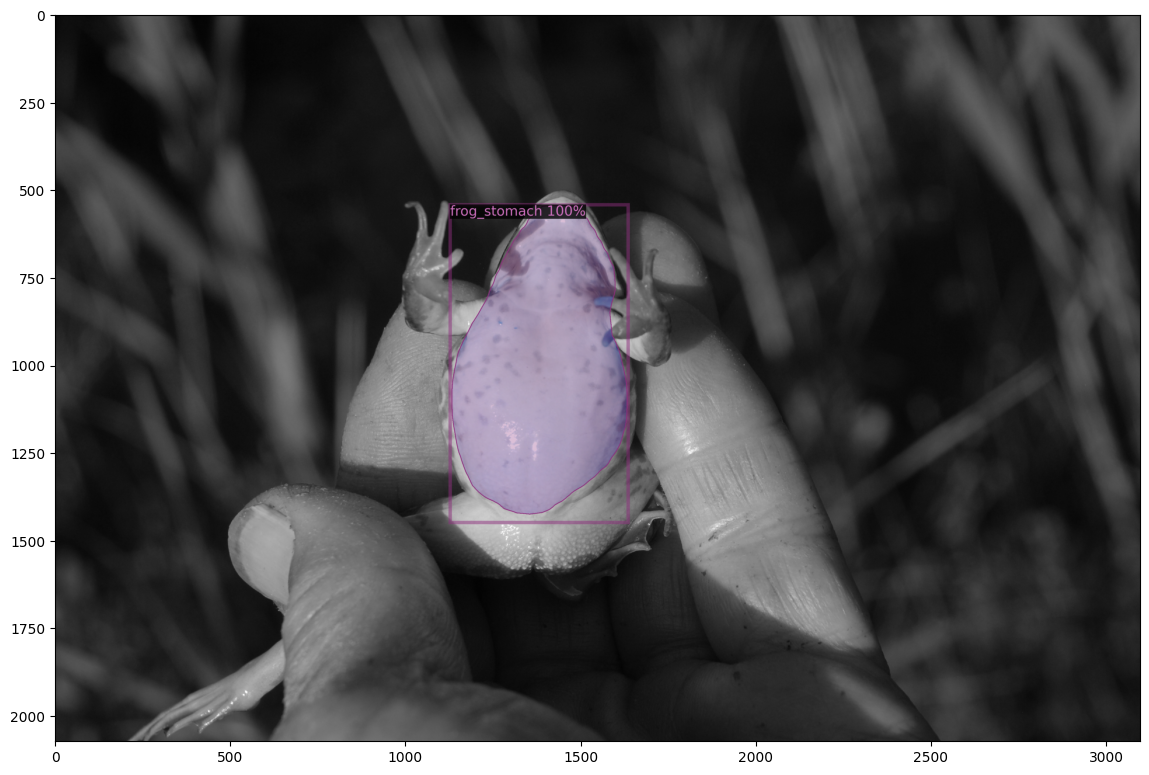

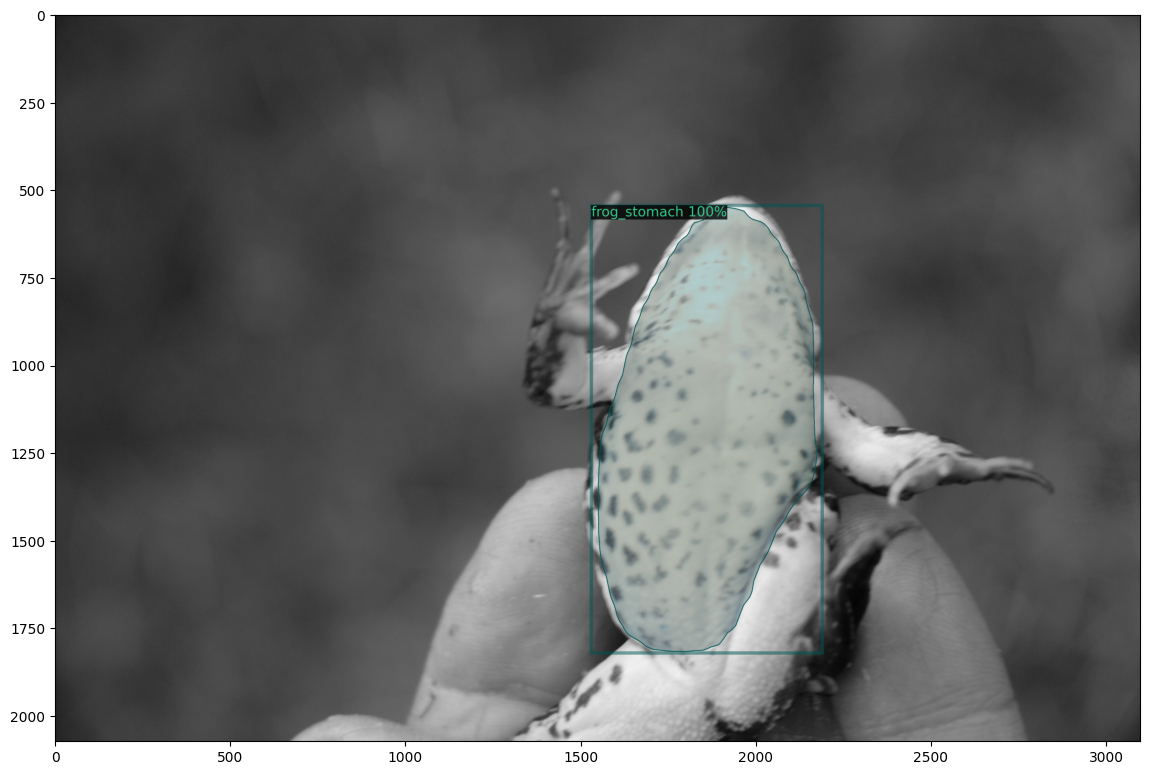

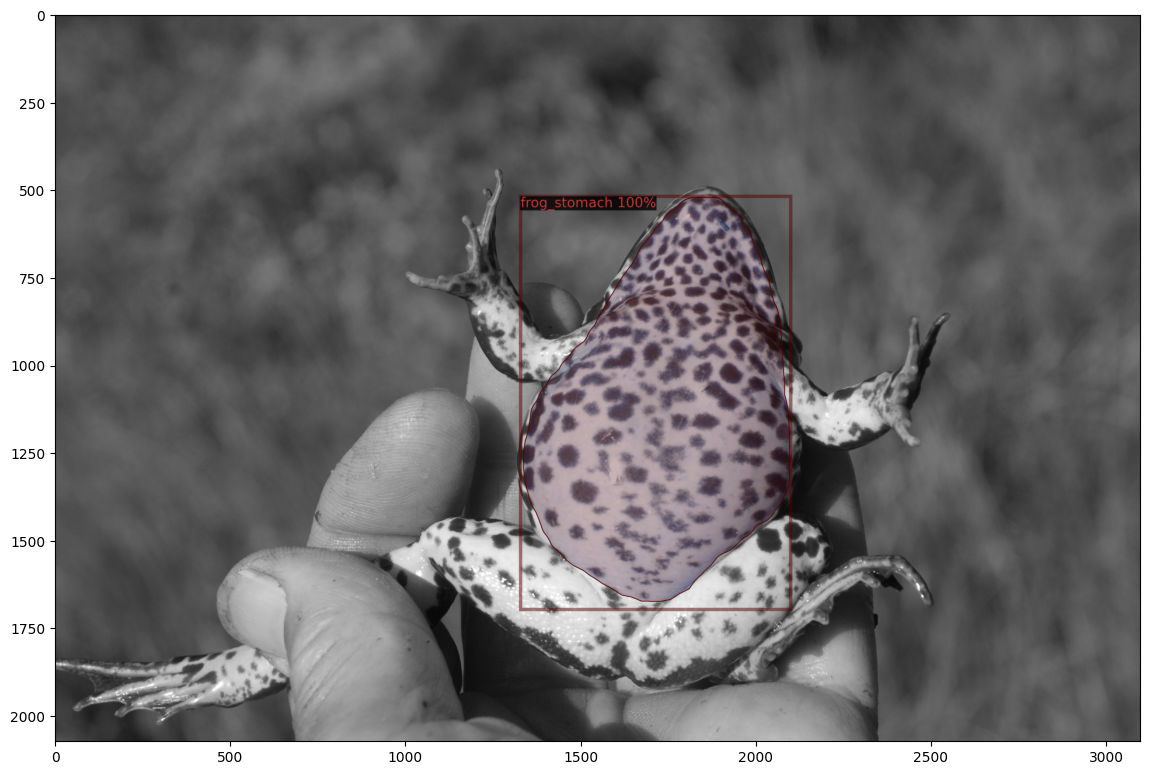

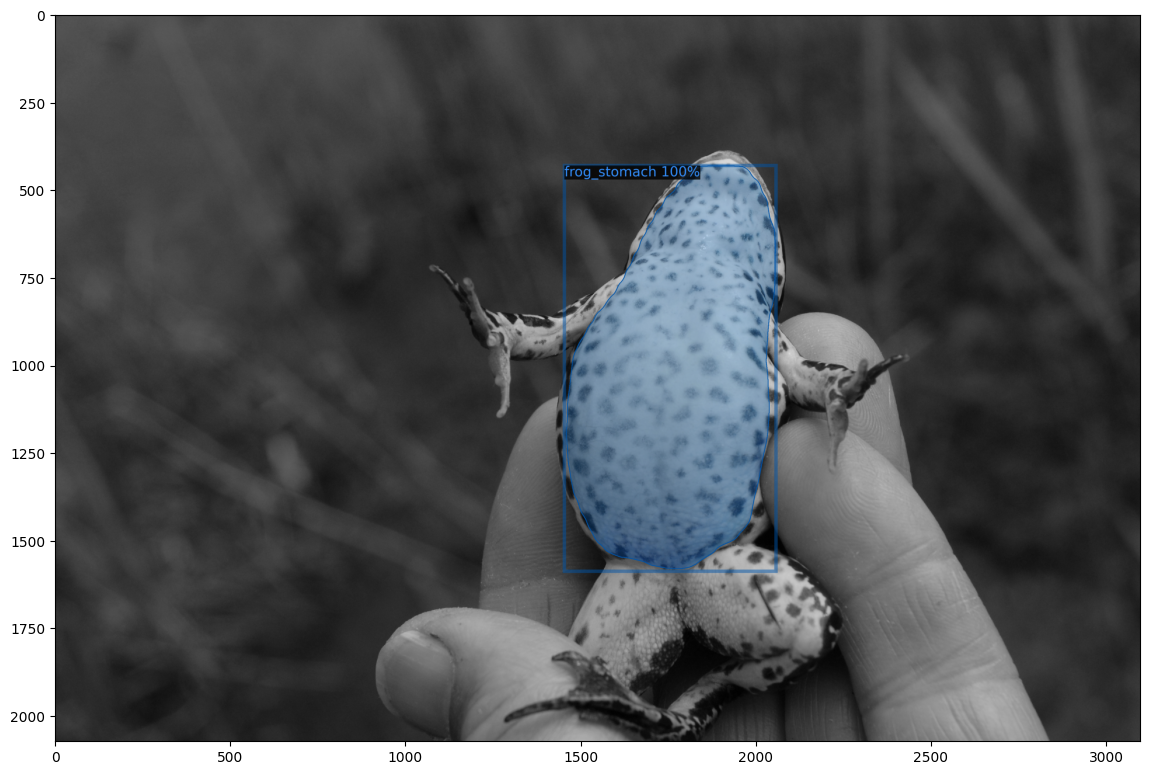

In [14]:
display_predictions(cfg, dataset_name, 5)

In [23]:
import torch
from detectron2.structures import Boxes, pairwise_iou
import numpy as np

def display_failures(cfg, dataset_name, iou_threshold=0.1, n_images=5):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
    predictor = DefaultPredictor(cfg)

    dataset_dicts = DatasetCatalog.get(dataset_name)
    fail_count = 0
    for d in dataset_dicts:    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        instances = outputs["instances"].to("cpu")

        # Extract ground truth and prediction boxes
        gt_boxes = [ann["bbox"] for ann in d["annotations"]]
        pred_boxes = instances.pred_boxes.tensor.numpy()

        # Compute IoU
        iou_matrix = pairwise_iou(Boxes(torch.tensor(gt_boxes)), Boxes(instances.pred_boxes.tensor))
        max_iou_per_pred = torch.max(iou_matrix, dim=0)[0]

        # Check for multiple detections and low IoU
        if len(pred_boxes) > len(gt_boxes) or torch.any(max_iou_per_pred < iou_threshold):
            v = Visualizer(im[:, :, ::-1],
                           metadata=MetadataCatalog.get(dataset_name), 
                           scale=0.8, 
                           instance_mode=ColorMode.IMAGE_BW
            )
            out = v.draw_instance_predictions(instances)
            plt.figure(figsize = (14, 10))
            plt.imshow(out.get_image()[:, :, ::-1])
            plt.show()
            fail_count += 1

        if fail_count >= n_images:
            break


[05/15 06:11:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2_models/model_final.pth ...
[05/15 06:11:09 d2.data.datasets.coco]: Loading data/split_segmentation_data/val.json takes 1.16 seconds.
[05/15 06:11:09 d2.data.datasets.coco]: Loaded 179 images in COCO format from data/split_segmentation_data/val.json


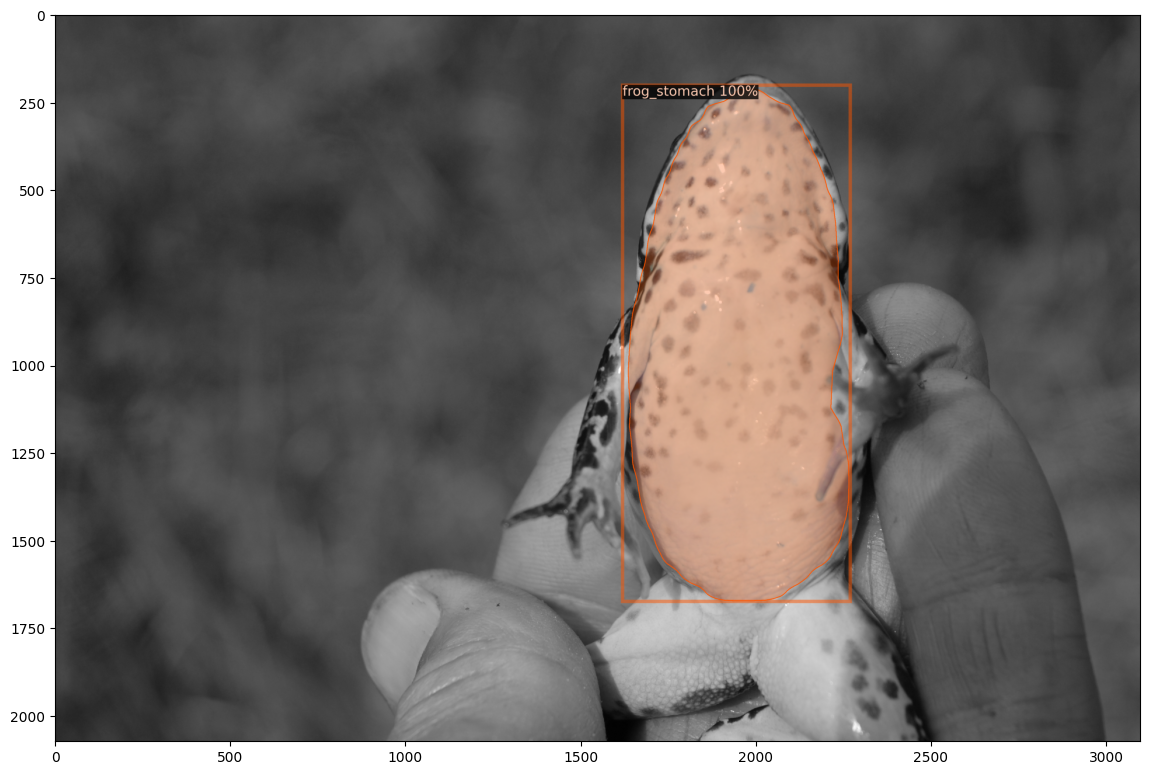

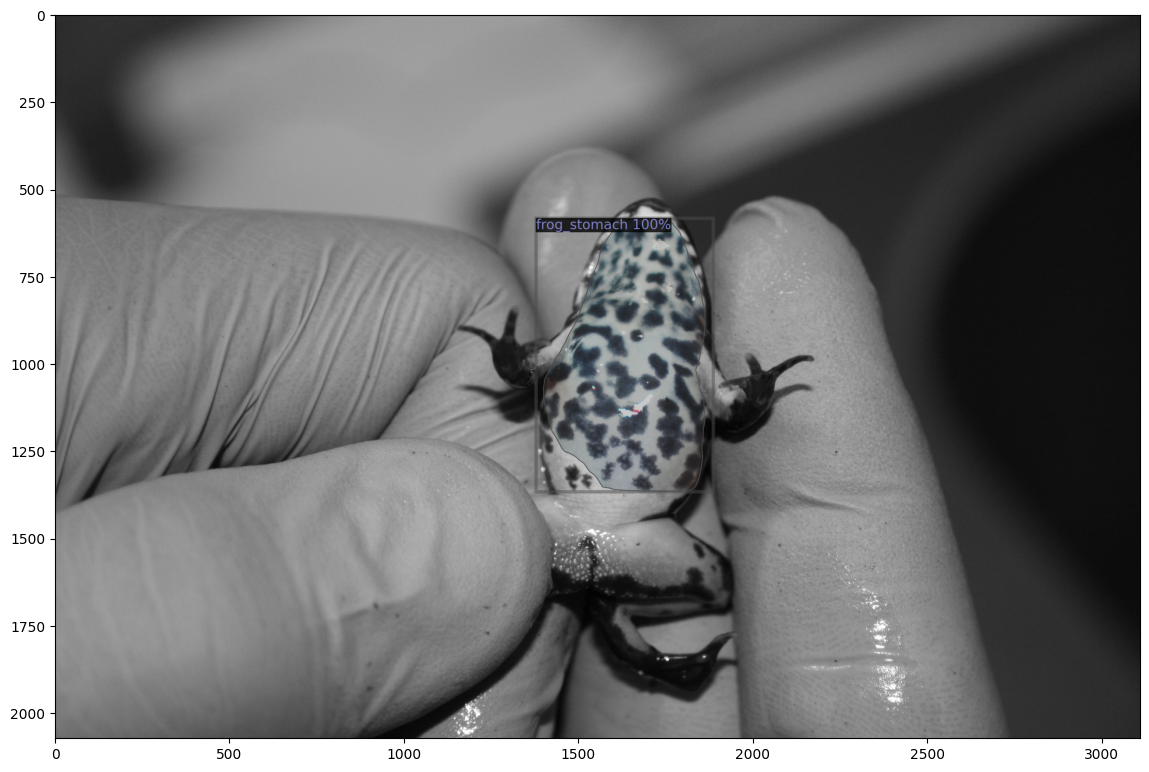

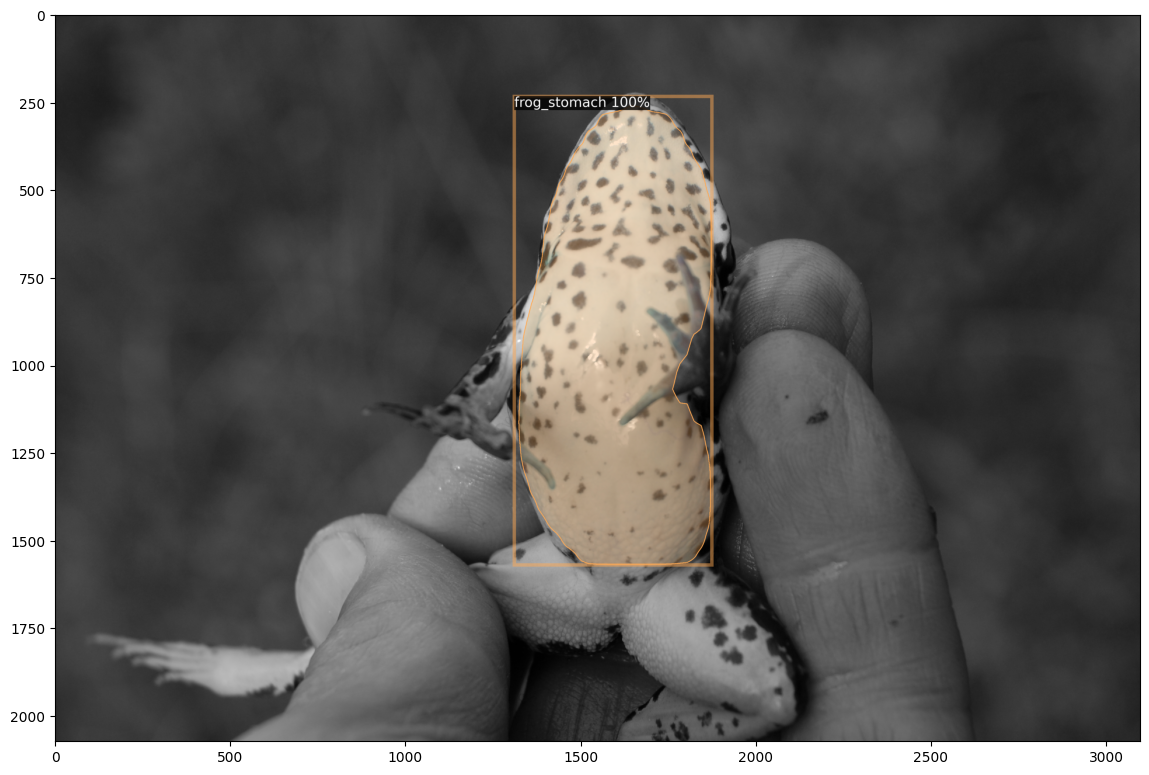

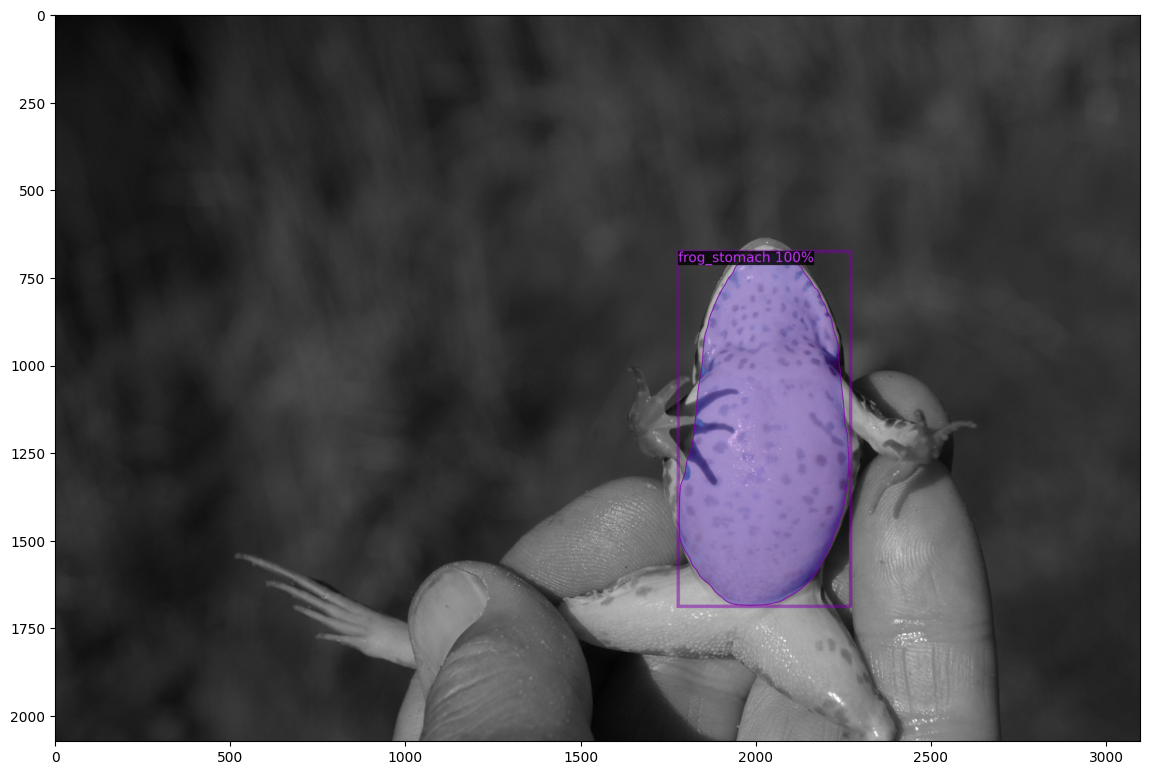

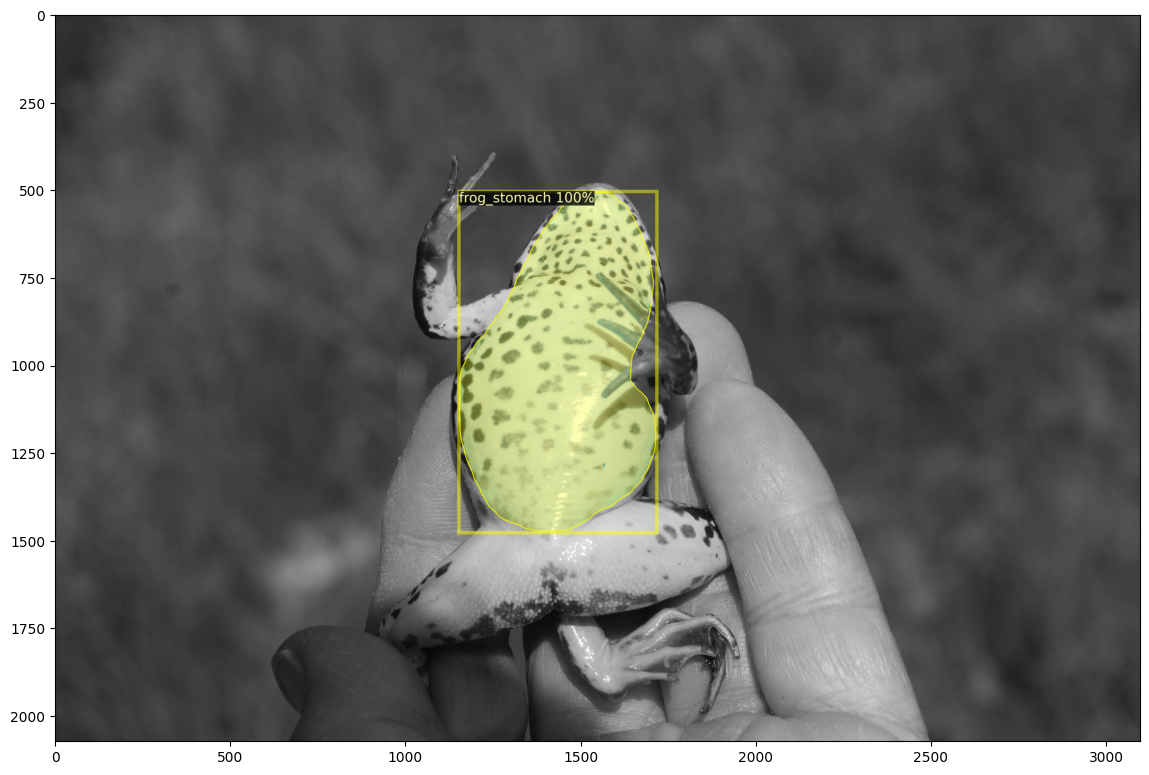

In [24]:
display_failures(cfg, "frog_stomach_val")